In [61]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import StaleElementReferenceException
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import time
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
from sklearn.metrics import brier_score_loss

### Wczytanie ramek danych

In [ ]:
pd.set_option('display.max_columns', None)
matches = pd.read_csv("data/matches_with_rolling_stats_pl.csv")
matches = matches[matches['round'] > 5]
matches.head(2)

,season,date,time,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch width m,latitude,lo

#### Przygotowanie ramki danych ze statystykami z ostatnich meczów

In [63]:
rolling_stats = matches[[col for col in matches.columns if 'last' in col or 'outcome' in col]]

In [64]:
rolling_stats.groupby(['outcome']).mean()

,home_last5_matches_played,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_goals_conceded,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_touches,home_last5_tackles,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_completed,home_last5_passes,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_completed_medium,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_live,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenges,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_tackles_interceptions,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_touches_live_ball,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_passes_received,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_matches_played,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_goals_conceded,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_touches,away_last5_tackles,away_last5_interceptions,away_last5_blocks,away_last5_xg,away_last5_npxg,away_last5_xg_assist,away_last5_sca,away_last5_gca,away_last5_passes_completed,away_last5_passes,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_total_distance,away_last5_passes_progressive_distance,away_last5_passes_completed_short,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_completed_medium,away_last5_passes_medium,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_live,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_kicks,away_last5_corner_kicks_in,away_last5_corner_ki

In [65]:
rolling_stats.head(2)

,outcome,home_last5_matches_played,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_goals_conceded,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_touches,home_last5_tackles,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_completed,home_last5_passes,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_completed_medium,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_live,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenges,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_tackles_interceptions,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_touches_live_ball,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_passes_received,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_matches_played,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_goals_conceded,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_touches,away_last5_tackles,away_last5_interceptions,away_last5_blocks,away_last5_xg,away_last5_npxg,away_last5_xg_assist,away_last5_sca,away_last5_gca,away_last5_passes_completed,away_last5_passes,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_total_distance,away_last5_passes_progressive_distance,away_last5_passes_completed_short,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_completed_medium,away_last5_passes_medium,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_live,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_kicks,away_last5_corner_kicks_in,away_last5_c

### Feature selection na bazie regresji logistycznej

In [66]:
X = rolling_stats.drop(columns=["outcome"])
y = rolling_stats["outcome"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
log_reg.fit(X_train, y_train)
model = SelectFromModel(log_reg, prefit=True)
selected_features = X.columns[model.get_support()]
print("Selected Features based on Logistic Regression:")
print(selected_features)
X_selected = model.transform(X_scaled)

Selected Features based on Logistic Regression:
Index(['home_last5_wins', 'home_last5_draws', 'home_last5_defeats',
       'home_last5_goal_difference', 'home_last5_goals_conceded',
       'home_last5_minutes', 'home_last5_goals', 'home_last5_assists',
       'home_last5_pens_made', 'home_last5_pens_att',
       ...
       'away_last5_fouled', 'away_last5_offsides', 'away_last5_pens_won',
       'away_last5_pens_conceded', 'away_last5_own_goals',
       'away_last5_ball_recoveries', 'away_last5_aerials_won',
       'away_last5_aerials_lost', 'away_last5_aerials_won_pct',
       'away_last5_points'],
      dtype='object', length=179)


In [67]:
rolling_stats =  pd.DataFrame(X_selected, columns=selected_features)
rolling_stats["outcome"] = y.reset_index(drop=True)

In [68]:
rolling_stats.groupby(['outcome']).mean()

,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_goals_conceded,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_goals_conceded,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_interceptions,away_last5_blocks,away_last5_npxg,away_last5_xg_assist,away_last5_gca,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_progressive_distance,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_kicks,away_last5_corner_kicks_in,away_last5_corner_kicks_out,away_last5_corner_kicks_straight,away_last5_passes_offsides,away_last5_passes_blocked,away_last5_tackles_won,away_last5_tackles_mid_3rd,away_last5_tackles_att_3rd,away_last5_challenge_tackles,away_last5_challenges,away_last5_challenge_tackles_pct,away_last5_challenges_lost,away_last5_blocked_shots,away_last5_blocked_passes,away_last5_tackles_interceptions,away_last5_clearances,away_last5_errors,away_last5_touches_def_pen_area,away_last5_touches_def_3rd,away_last5_touches_mid_3rd,away_last5_touches_att_3rd,away_last5_touches_att_pen_area,away_last5_take_ons_won_pct,away_l

#### Wczytywanie danych do torcha

In [69]:
class FootballDataset(Dataset):
    def __init__(self, agg_stats):
        self.agg_stats = agg_stats.drop('outcome', axis=1).values  # Convert to numpy array
        self.labels = agg_stats['outcome'].values  # Convert to numpy array
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Return features and labels as tensors
        features = torch.tensor(self.agg_stats[idx], dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, labels

In [70]:
train_df, test_df = train_test_split(rolling_stats, test_size=0.4, random_state=42)
dataset = FootballDataset(train_df)
test_dataset = FootballDataset(test_df)
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

##### Customowa loss function - raczej się nie nadaje, ale można opisać próby jakby co póżniej

In [71]:
# def distance_penalty_loss(predictions, targets, penalty_factor=0.5):
#     # Apply softmax to get probabilities
#     predictions_probs = F.softmax(predictions, dim=1)

#     # Get the predicted class index (most confident prediction)
#     predicted_class = torch.argmax(predictions_probs, dim=1)
    
#     # Calculate the cross-entropy loss as usual
#     cross_entropy_loss = F.cross_entropy(predictions, targets, reduction='none')

#     # Calculate the distance between predicted class and true class
#     distance = (predicted_class != targets).float()
    
#     max_values, _ = torch.max(predictions_probs, dim=1)

#     # Apply a penalty based on the distance (e.g., penalty factor of 2.0)
#     penalty = 1 + penalty_factor * distance

#     # Return the mean penalized loss over the batch
#     penalized_loss = cross_entropy_loss * penalty * (max_values + 3)
#     return penalized_loss.mean()

#### Prosta sieć neuronowa z 3 warstwami

In [72]:
class FootballMatchPredictor(nn.Module):
    def __init__(self, input_agg_stats_size, hidden_size=64):
        super(FootballMatchPredictor, self).__init__()
        
        # Layer for aggregated statistics
        self.agg_stats_fc = nn.Sequential(
            nn.Linear(input_agg_stats_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        combined_input_size = hidden_size
        self.fc_combined = nn.Sequential(
            nn.Linear(combined_input_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 3),  # Output: 3 probabilities (home win/draw/away win)
        )

    def forward(self, agg_stats):

        agg_stats_out = self.agg_stats_fc(agg_stats)

        output = self.fc_combined(agg_stats_out)
        
        # Apply softmax to get probabilities
        return F.softmax(output, dim=1)

#### Narazie najlepsza loss function - która gwarantuje, że prawdopodbieństwo remisów nie jest zbyt małe jak w przypadku innych loss functions

In [88]:
def weighted_cross_entropy_loss(predictions, targets):
    smoothing = 0.3
    weight_matrix = torch.tensor([
    [1.0, 2.0, 2.0],  # True label is draw (heavier penalty for home/away win predictions)
    [1.0, 1.0, 2.0],  # True label is home win
    [1.0, 2.0, 1.0]   # True label is away win
    ])
    # Apply softmax to get probabilities
    predictions_probs = F.softmax(predictions, dim=1)
    
    # One-hot encode the target labels (0 = draw, 1 = home win, 2 = away win)
    one_hot_targets = F.one_hot(targets, num_classes=3).float()

    smoothed_targets = one_hot_targets.clone()
    for i, target in enumerate(targets):
        if target == 0:  # If the true class is 'draw'
            smoothed_targets[i] = torch.tensor([0.8, 0.1, 0.1])  # 0.8 for draw, 0.1 for home/away win
        elif target == 1:  # If the true class is 'home win'
            smoothed_targets[i] = torch.tensor([0.22, 0.66, 0.12])
        elif target == 2:  # If the true class is 'away win'
            smoothed_targets[i] = torch.tensor([0.20, 0.1, 0.7])
    

    # Calculate the cross-entropy loss for each class
    loss_per_class = -smoothed_targets * torch.log(predictions_probs)
    # Weight the loss based on the distance between predicted and true class
    # For each true class, apply the corresponding row of the weight matrix
    weights = weight_matrix[targets]  # Get the corresponding weight row for each true label
    weighted_loss = loss_per_class * weights

    # Return the mean weighted loss over the batch
    return weighted_loss.sum(dim=1).mean()


In [74]:
def brier_score_loss(predictions, targets):
    predictions_probs = F.softmax(predictions, dim=1)
    one_hot_targets = F.one_hot(targets, num_classes=3).float()
    loss_per_class = (predictions_probs - one_hot_targets) ** 2
    return loss_per_class.sum(dim=1).mean()

### Trenowanie modelu

In [90]:
model = FootballMatchPredictor(179)

# Loss function and optimizer
criterion = weighted_cross_entropy_loss  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


# Training loop
num_epochs = 5 
batch_size = 32 

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):


        # # Move data to device (GPU/CPU)
        # inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs
        # targets = targets.to('cuda') if torch.cuda.is_available() else targets
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Optimize weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'football_match_predictor.pth')

Epoch 1/5:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 297/297 [00:01<00:00, 241.53it/s]


Epoch [1/5], Loss: 1.2402


Epoch 2/5: 100%|██████████| 297/297 [00:01<00:00, 237.68it/s]


Epoch [2/5], Loss: 1.2316


Epoch 3/5: 100%|██████████| 297/297 [00:01<00:00, 262.01it/s]


Epoch [3/5], Loss: 1.2259


Epoch 4/5: 100%|██████████| 297/297 [00:01<00:00, 280.78it/s]


Epoch [4/5], Loss: 1.2233


Epoch 5/5: 100%|██████████| 297/297 [00:01<00:00, 262.01it/s]

Epoch [5/5], Loss: 1.2208


### Ocena modelu

In [124]:
model.eval()

# To make predictions, you can create a DataLoader for your new data or use existing data.
# For this example, let's say we want to make predictions on the validation dataset.
# If you have a specific dataset or inputs, make sure it's in the correct format.

# Here we assume you want to predict on a subset of your training dataset for demonstration.
# If you're predicting on new data, load that data into a DataLoader accordingly.

with torch.no_grad():  # Disable gradient calculation for predictions
    predictions = []
    probabilities=[]
    actuals = []  # To store actual outcomes if you have them for comparison

    for inputs, targets in test_dataloader:  # You can replace dataloader with your validation/test DataLoader
        
        # Get model outputs
        outputs = model(inputs)  # Shape will be [batch_size, 3]
        
        # Get the predicted class indices (argmax to get the class with highest probability)
        _, predicted_classes = torch.max(outputs, dim=1)
        
        # Store predictions and actuals
        probabilities.extend(outputs)
        predictions.extend(predicted_classes.cpu().numpy())  # Convert to numpy for easy handling
        actuals.extend(targets.numpy())  # Store actual targets

# Now predictions contains the predicted class indices for the input data
# and actuals contains the true class labels (if available).

# Optionally, print the results
print("Predictions:", probabilities)
print("Predictions:", predictions)
print("Actuals:    ", actuals)

# You can calculate accuracy or other metrics if you have actual labels
accuracy = (np.array(predictions) == np.array(actuals)).mean()
print(f'Accuracy: {accuracy:.4f}')

conf_matrix = confusion_matrix(actuals, predictions)
print("Confusion Matrix:\n", conf_matrix)

probabilities = torch.stack(probabilities).numpy()
bin_edges = np.arange(0, 1.1, 0.1)
home_win_probs = probabilities[:, 1]
away_win_probs = probabilities[:, 2]
draw_probs = probabilities[:, 0]
df = pd.DataFrame({
    'home_win_prob': home_win_probs,
    'away_win_prob': away_win_probs,
    'draw_prob': draw_probs,
    'actual': actuals
})
df['prob_bin1'] = pd.cut(df['home_win_prob'], bins=bin_edges, labels=bin_edges[:-1])
df['prob_bin2'] = pd.cut(df['away_win_prob'], bins=bin_edges, labels=bin_edges[:-1])
df['prob_bin0'] = pd.cut(df['draw_prob'], bins=bin_edges, labels=bin_edges[:-1])
bin_results0 = df.groupby('prob_bin0', observed=False).apply(lambda x: (x['actual'] == 0).mean(), include_groups=False)
bin_results1 = df.groupby('prob_bin1', observed=False).apply(lambda x: (x['actual'] == 1).mean(), include_groups=False)
bin_results2 = df.groupby('prob_bin2', observed=False).apply(lambda x: (x['actual'] == 2).mean(), include_groups=False)
comparison = pd.DataFrame({
    'Expected Probability of Home Win': (bin_results1.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Home Win %': bin_results1.values * 100,  # Convert to percentage
    'Expected Probability of Away Win': (bin_results2.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Away Win %': bin_results2.values * 100,  # Convert to percentage
    'Expected Probability of Draw': (bin_results0.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Draw %': bin_results0.values * 100  # Convert to percentage
})
comparison

Predictions: [tensor([0.2929, 0.3242, 0.3829]), tensor([0.2395, 0.5376, 0.2229]), tensor([0.2921, 0.3801, 0.3278]), tensor([0.2229, 0.5887, 0.1885]), tensor([0.2799, 0.2793, 0.4408]), tensor([0.2261, 0.5733, 0.2006]), tensor([0.2435, 0.5750, 0.1815]), tensor([0.2578, 0.2680, 0.4742]), tensor([0.1806, 0.6860, 0.1333]), tensor([0.2514, 0.2870, 0.4616]), tensor([0.2953, 0.4124, 0.2923]), tensor([0.2865, 0.4395, 0.2740]), tensor([0.2854, 0.4733, 0.2414]), tensor([0.1814, 0.1840, 0.6346]), tensor([0.2587, 0.5286, 0.2128]), tensor([0.1991, 0.6774, 0.1235]), tensor([0.1801, 0.6971, 0.1227]), tensor([0.2984, 0.3774, 0.3242]), tensor([0.2451, 0.4556, 0.2993]), tensor([0.1090, 0.8396, 0.0514]), tensor([0.1938, 0.6594, 0.1468]), tensor([0.2656, 0.3058, 0.4286]), tensor([0.1846, 0.1797, 0.6357]), tensor([0.2979, 0.3682, 0.3339]), tensor([0.2770, 0.4297, 0.2934]), tensor([0.3009, 0.3572, 0.3420]), tensor([0.2707, 0.5073, 0.2220]), tensor([0.2582, 0.5343, 0.2075]), tensor([0.2594, 0.5355, 0.2051]), 

,Expected Probability of Home Win,Observed Home Win %,Expected Probability of Away Win,Observed Away Win %,Expected Probability of Draw,Observed Draw %
0,5.0,8.333333,5.0,2.631579,5.0,0.000000
1,15.0,12.500000,15.0,15.000000,15.0,18.604651
2,25.0,26.315789,25.0,22.448980,25.0,23.519164
3,35.0,40.000000,35.0,36.666667,35.0,32.258065
4,45.0,50.666667,45.0,42.222222,45.0,NaN
5,55.0,52.678571,55.0,52.380952,55.0,NaN
6,65.0,71.568627,65.0,59.649123,65.0,NaN
7,75.0,75.675676,75.0,70.967742,75.0,NaN
8,85.0,85.714286,85.0,100.000000,85.0,NaN
9,95.0,100.000000,95.0,NaN,95.0,NaN


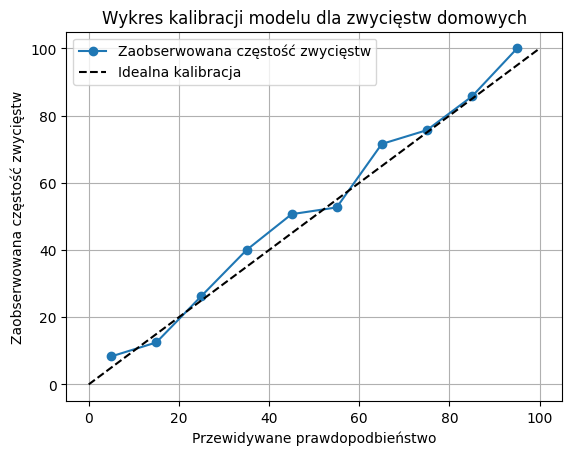

In [92]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results1.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość zwycięstw")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji modelu dla zwycięstw domowych")
plt.legend()
plt.grid()
plt.show()

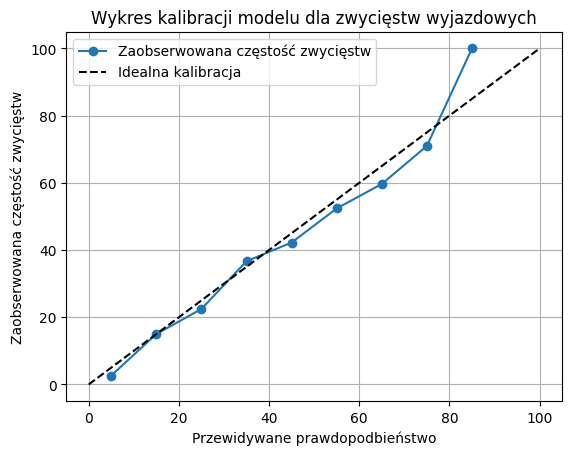

In [93]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results2.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość zwycięstw")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji modelu dla zwycięstw wyjazdowych")
plt.legend()
plt.grid()
plt.show()

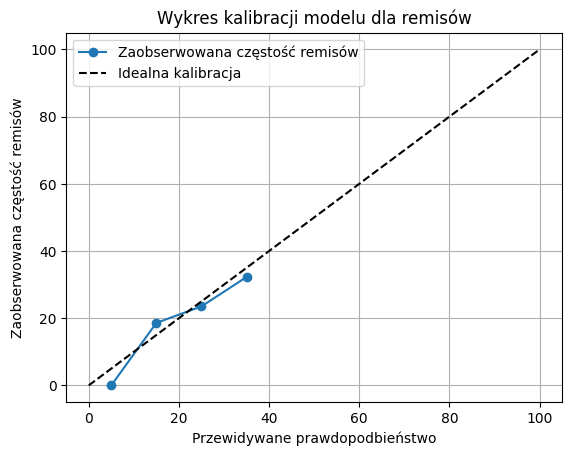

In [94]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results0.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość remisów")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość remisów")
plt.title("Wykres kalibracji modelu dla remisów")
plt.legend()
plt.grid()
plt.show()

### Losowanie wyników - nie działa

In [81]:
random_probs_outcome = []
for probs in probabilities:
    random_probs_outcome.append(random.choices([0, 1, 2], weights=probs, k=1)[0])
accuracy = (np.array(random_probs_outcome) == np.array(actuals)).mean()
print("Predictions:", random_probs_outcome)
print("Actuals:    ", actuals)
print(f'Accuracy: {accuracy:.4f}')
conf_matrix = confusion_matrix(actuals, random_probs_outcome)
print("Confusion Matrix:\n", conf_matrix)

Predictions: [2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 1, 2, 2, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2,

### Sprawdzenie z danymi bukmacherów

In [114]:
odds_23_24 = pd.read_csv("data/E0_23-24.csv")
odds_22_23 = pd.read_csv("data/E0_22-23.csv")
odds_21_22 = pd.read_csv("data/E0_21-22.csv")
odds_20_21 = pd.read_csv("data/E0_20-21.csv")
odds_19_20 = pd.read_csv("data/E0_19-20.csv")
odds_18_19 = pd.read_csv("data/E0_18-19.csv")
odds = pd.concat([odds_23_24, odds_22_23, odds_21_22, odds_20_21, odds_19_20, odds_18_19], ignore_index=True)

In [115]:
team_name_mapping = {
    'Burnley': 'Burnley',
    'Arsenal': 'Arsenal',
    'Bournemouth': 'Bournemouth',
    'Brighton': 'Brighton & Hove Albion',
    'Everton': 'Everton',
    'Sheffield United': 'Sheffield United',
    'Newcastle': 'Newcastle United',
    'Brentford': 'Brentford',
    'Chelsea': 'Chelsea',
    'Man United': 'Manchester United',
    "Nott'm Forest": 'Nottingham Forest',
    'Fulham': 'Fulham',
    'Liverpool': 'Liverpool',
    'Wolves': 'Wolverhampton Wanderers',
    'Tottenham': 'Tottenham Hotspur',
    'Man City': 'Manchester City',
    'Aston Villa': 'Aston Villa',
    'West Ham': 'West Ham United',
    'Crystal Palace': 'Crystal Palace',
    'Luton': 'Luton Town',
    'Leeds': 'Leeds United',
    'Leicester': 'Leicester City',
    'Southampton': 'Southampton',
    'Watford': 'Watford',
    'Norwich': 'Norwich City',
    'West Brom': 'West Bromwich Albion',
    'Huddersfield': 'Huddersfield Town',
    'Cardiff': 'Cardiff City'
}

odds['HomeTeam'] = odds['HomeTeam'].map(team_name_mapping)
odds['AwayTeam'] = odds['AwayTeam'].map(team_name_mapping)

In [116]:
odds['Date'] = pd.to_datetime(odds['Date'], format='%d/%m/%Y')
matches['date'] = pd.to_datetime(matches['date'])
odds = odds[["Date", "HomeTeam", "AwayTeam", "B365H", "B365D", "B365A"]]
odds.rename(columns={
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team'
}, inplace=True)

In [117]:
merged_df = pd.merge(
    matches,
    odds,
    how='inner',
    left_on=['home_team', 'away_team', 'date'],
    right_on=['home_team', 'away_team', 'Date']
)
merged_df.drop(columns=['Date'], inplace=True)
merged_df.head(2)

,season,date,time,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,total_goals,Stadium,Club,Location,Capacity,Pitch length m,Pitch width m,latitude,lo

In [118]:
merged_df["B365probsH"] = 1 / merged_df["B365H"] / (1 / merged_df["B365H"] + 1 / merged_df["B365D"] + 1 / merged_df["B365A"])
merged_df["B365probsD"] = 1 / merged_df["B365D"] / (1 / merged_df["B365H"] + 1 / merged_df["B365D"] + 1 / merged_df["B365A"])
merged_df["B365probsA"] = 1 / merged_df["B365A"] / (1 / merged_df["B365H"] + 1 / merged_df["B365D"] + 1 / merged_df["B365A"])

In [123]:
bin_edges = np.arange(0, 1.1, 0.1)
home_win_probs = merged_df["B365probsH"]
away_win_probs = merged_df["B365probsA"]
draw_probs = merged_df["B365probsD"]
actuals = merged_df["outcome"]
df = pd.DataFrame({
    'home_win_prob': home_win_probs,
    'away_win_prob': away_win_probs,
    'draw_prob': draw_probs,
    'actual': actuals
})
df['prob_bin1'] = pd.cut(df['home_win_prob'], bins=bin_edges, labels=bin_edges[:-1])
df['prob_bin2'] = pd.cut(df['away_win_prob'], bins=bin_edges, labels=bin_edges[:-1])
df['prob_bin0'] = pd.cut(df['draw_prob'], bins=bin_edges, labels=bin_edges[:-1])
bin_results0 = df.groupby('prob_bin0', observed=False).apply(lambda x: (x['actual'] == 0).mean(), include_groups=False)
bin_results1 = df.groupby('prob_bin1', observed=False).apply(lambda x: (x['actual'] == 1).mean(), include_groups=False)
bin_results2 = df.groupby('prob_bin2', observed=False).apply(lambda x: (x['actual'] == 2).mean(), include_groups=False)
comparison = pd.DataFrame({
    'Expected Probability of Home Win': (bin_results1.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Home Win %': bin_results1.values * 100,  # Convert to percentage
    'Expected Probability of Away Win': (bin_results2.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Away Win %': bin_results2.values * 100,  # Convert to percentage
    'Expected Probability of Draw': (bin_results0.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Draw %': bin_results0.values * 100  # Convert to percentage
})
comparison

,Expected Probability of Home Win,Observed Home Win %,Expected Probability of Away Win,Observed Away Win %,Expected Probability of Draw,Observed Draw %
0,5.0,3.225806,5.0,8.376963,5.0,8.823529
1,15.0,16.500000,15.0,15.736041,15.0,16.030534
2,25.0,29.390681,25.0,25.295508,25.0,23.777629
3,35.0,35.849057,35.0,34.584450,35.0,23.333333
4,45.0,44.285714,45.0,44.489796,45.0,NaN
5,55.0,60.150376,55.0,51.315789,55.0,NaN
6,65.0,67.873303,65.0,70.338983,65.0,NaN
7,75.0,69.064748,75.0,79.411765,75.0,NaN
8,85.0,88.888889,85.0,87.500000,85.0,NaN
9,95.0,100.000000,95.0,NaN,95.0,NaN


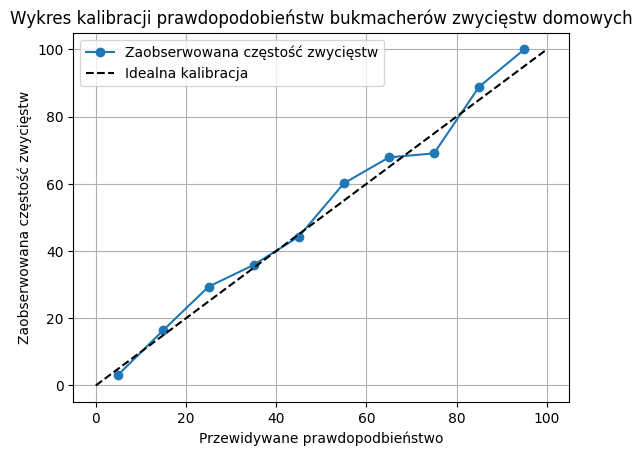

In [121]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results1.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość zwycięstw")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji prawdopodobieństw bukmacherów zwycięstw domowych")
plt.legend()
plt.grid()
plt.show()

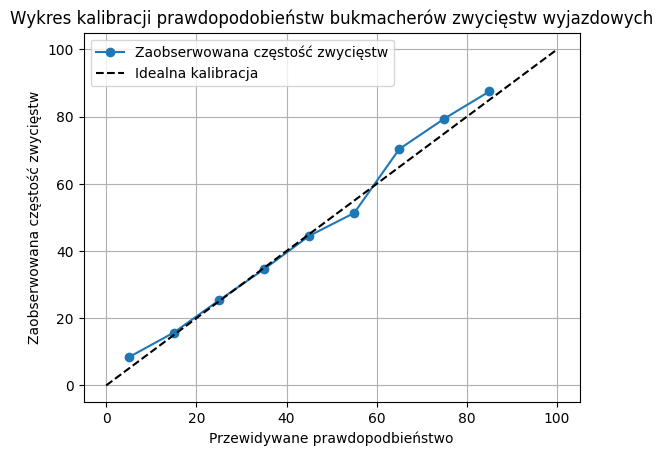

In [112]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results2.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość zwycięstw")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji prawdopodobieństw bukmacherów zwycięstw wyjazdowych")
plt.legend()
plt.grid()
plt.show()

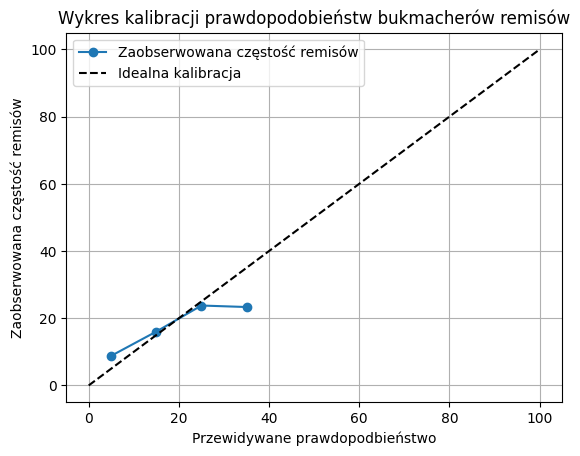

In [113]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results0.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość remisów")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość remisów")
plt.title("Wykres kalibracji prawdopodobieństw bukmacherów remisów")
plt.legend()
plt.grid()
plt.show()